In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=400 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = cm_target[-10:-7]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((n_cases,2,5,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    #total_coords = np.hstack((airfoil_coord, flap_coords))
    total_coords = flap_coords
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,5))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (3000, 2)
Dimension - airfoil coordinates:  (6000, 50)
Dimension - coord with flaps:  (6000, 5)
Dimension - total coordinates:  (6000, 5)
Dimension - x_time:  (3000, 1)
Dimension - x_coordinates:  (3000, 2, 5, 1)
Dimension - y:  (3000, 1)


In [21]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [22]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [23]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [24]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,5,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [25]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 5, 1)]    0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 5, 400)    2000        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 2, 400)    0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 800)          0           ['max_pooling2d[0][0]']          
                                                                                              

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20230102\\3Case(131415)(l2)(flapOnly)"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20230102unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly)_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
10/10 [==============================] - ETA: 0s - loss: 0.1712 - rmse: 0.4137 
Epoch 1: val_loss improved from inf to 0.16343, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)(flapOnly)20230102unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 4s 33ms/step - loss: 0.1712 - rmse: 0.4137 - val_loss: 0.1634 - val_rmse: 0.4041 - lr: 1.0000e-04
Epoch 2/10000
10/10 [==============================] - ETA: 0s - loss: 0.1355 - rmse: 0.3679
Epoch 2: val_loss improved from 0.16343 to 0.12780, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)(flapOnly)20230102unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.1355 - rmse: 0.3679 - val_loss: 0.1278 - val_rmse: 0.3573 - lr: 1.0000e-04
Epoch 3/10000
10/10 [==============================] - ETA: 0s - loss

10/10 [==============================] - 0s 23ms/step - loss: 0.0288 - rmse: 0.1694 - val_loss: 0.0268 - val_rmse: 0.1632 - lr: 1.0000e-04
Epoch 19/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0240 - rmse: 0.1545
Epoch 19: val_loss improved from 0.02676 to 0.02213, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)(flapOnly)20230102unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 0.0232 - rmse: 0.1518 - val_loss: 0.0221 - val_rmse: 0.1483 - lr: 1.0000e-04
Epoch 20/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0210 - rmse: 0.1444
Epoch 20: val_loss improved from 0.02213 to 0.01923, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)(flapOnly)20230102unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 28ms/step - loss: 

 6/10 [=================>............] - ETA: 0s - loss: 0.0030 - rmse: 0.0532
Epoch 36: val_loss improved from 0.00267 to 0.00249, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)(flapOnly)20230102unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 24ms/step - loss: 0.0029 - rmse: 0.0522 - val_loss: 0.0025 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 37/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0028 - rmse: 0.0514
Epoch 37: val_loss improved from 0.00249 to 0.00236, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)(flapOnly)20230102unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 24ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0024 - val_rmse: 0.0471 - lr: 1.0000e-04
Epoch 38/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.002

 6/10 [=================>............] - ETA: 0s - loss: 0.0014 - rmse: 0.0361
Epoch 55: val_loss did not improve from 0.00133
10/10 [==============================] - 0s 14ms/step - loss: 0.0015 - rmse: 0.0370 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 56/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0015 - rmse: 0.0363
Epoch 56: val_loss improved from 0.00133 to 0.00123, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)(flapOnly)20230102unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 24ms/step - loss: 0.0015 - rmse: 0.0373 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 57/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0015 - rmse: 0.0363
Epoch 57: val_loss did not improve from 0.00123
10/10 [==============================] - 0s 14ms/step - loss: 0.0015 - rmse: 0.0373 - val_loss: 0.0013 - val_rmse: 0.0340 -

Epoch 80/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0323
Epoch 80: val_loss did not improve from 0.00101
10/10 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0324 - val_loss: 0.0010 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 81/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0320
Epoch 81: val_loss did not improve from 0.00101
10/10 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0326 - val_loss: 0.0011 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 82/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 82: val_loss did not improve from 0.00101
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0011 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 83/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 83: val_loss did not improve from 0.00101
10/10 [========

 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 106: val_loss did not improve from 0.00092
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0307 - val_loss: 0.0011 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 107/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0307
Epoch 107: val_loss did not improve from 0.00092
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0311 - val_loss: 9.7723e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 108/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0302
Epoch 108: val_loss did not improve from 0.00092
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0308 - val_loss: 9.6633e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 109/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 109: val_loss did not improve from 0.00092
10/10 [========

10/10 [==============================] - 0s 12ms/step - loss: 9.7789e-04 - rmse: 0.0292 - val_loss: 9.7398e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 133/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9547e-04 - rmse: 0.0295
Epoch 133: val_loss did not improve from 0.00090
10/10 [==============================] - 0s 12ms/step - loss: 9.7742e-04 - rmse: 0.0292 - val_loss: 8.9785e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 134/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0301
Epoch 134: val_loss did not improve from 0.00090
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0299 - val_loss: 9.1603e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 135/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5335e-04 - rmse: 0.0288
Epoch 135: val_loss did not improve from 0.00090
10/10 [==============================] - 0s 13ms/step - loss: 9.5385e-04 - rmse: 0.0288 - val_loss: 9.1820e-04 - val_rmse: 

 7/10 [====================>.........] - ETA: 0s - loss: 9.8203e-04 - rmse: 0.0294
Epoch 160: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 9.9137e-04 - rmse: 0.0295 - val_loss: 8.9941e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 161/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6781e-04 - rmse: 0.0291
Epoch 161: val_loss improved from 0.00089 to 0.00089, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)(flapOnly)20230102unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 24ms/step - loss: 9.5529e-04 - rmse: 0.0289 - val_loss: 8.8565e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 162/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.8813e-04 - rmse: 0.0295
Epoch 162: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 14ms/step - loss: 9.8716e-04 - rmse: 0.0294 - 

10/10 [==============================] - 0s 13ms/step - loss: 9.7007e-04 - rmse: 0.0292 - val_loss: 9.5729e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 188/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8658e-04 - rmse: 0.0295
Epoch 188: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0298 - val_loss: 9.3060e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 189/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5888e-04 - rmse: 0.0290
Epoch 189: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 9.3936e-04 - rmse: 0.0287 - val_loss: 9.3150e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 190/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2487e-04 - rmse: 0.0285
Epoch 190: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 9.7701e-04 - rmse: 0.0294 - val_loss: 0.0010 - val_rmse: 

Epoch 216/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0301
Epoch 216: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0310 - val_loss: 0.0011 - val_rmse: 0.0312 - lr: 1.0000e-04
Epoch 217/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 217: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0323 - val_loss: 9.6980e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 218/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6521e-04 - rmse: 0.0292
Epoch 218: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 219/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 219: val_loss did not improve from 0.00089

10/10 [==============================] - 0s 13ms/step - loss: 9.7600e-04 - rmse: 0.0295 - val_loss: 9.7703e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 244/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9627e-04 - rmse: 0.0281
Epoch 244: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.2704e-04 - rmse: 0.0286 - val_loss: 0.0010 - val_rmse: 0.0299 - lr: 1.0000e-04
Epoch 245/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6998e-04 - rmse: 0.0294
Epoch 245: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 12ms/step - loss: 9.6664e-04 - rmse: 0.0293 - val_loss: 9.3272e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 246/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9326e-04 - rmse: 0.0280
Epoch 246: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.0704e-04 - rmse: 0.0283 - val_loss: 9.1099e-04 - val_rm

10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0299 - val_loss: 9.5832e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 272/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2702e-04 - rmse: 0.0287
Epoch 272: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.3148e-04 - rmse: 0.0288 - val_loss: 9.4071e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 273/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3109e-04 - rmse: 0.0288
Epoch 273: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.5414e-04 - rmse: 0.0292 - val_loss: 0.0010 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 274/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4981e-04 - rmse: 0.0291
Epoch 274: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.4803e-04 - rmse: 0.0291 - val_loss: 9.2942e-04 - val_rmse: 

Epoch 299/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6446e-04 - rmse: 0.0294
Epoch 299: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.4002e-04 - rmse: 0.0290 - val_loss: 9.3539e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 300/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3300e-04 - rmse: 0.0289
Epoch 300: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.0327e-04 - rmse: 0.0283 - val_loss: 9.7731e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 301/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0309
Epoch 301: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 9.1280e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 302/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0303
Epoch 302: val_loss did not 

 7/10 [====================>.........] - ETA: 0s - loss: 9.3193e-04 - rmse: 0.0289
Epoch 327: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.7671e-04 - rmse: 0.0297 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 328/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7524e-04 - rmse: 0.0296
Epoch 328: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 12ms/step - loss: 9.6674e-04 - rmse: 0.0295 - val_loss: 9.6152e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 329/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5923e-04 - rmse: 0.0294
Epoch 329: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.6438e-04 - rmse: 0.0295 - val_loss: 0.0010 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 330/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6407e-04 - rmse: 0.0295
Epoch 330: val_loss did not improve from

10/10 [==============================] - 0s 13ms/step - loss: 8.9787e-04 - rmse: 0.0284 - val_loss: 9.5593e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 355/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8970e-04 - rmse: 0.0299
Epoch 355: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.6000e-04 - rmse: 0.0294 - val_loss: 8.8795e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 356/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9460e-04 - rmse: 0.0283
Epoch 356: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 12ms/step - loss: 9.1781e-04 - rmse: 0.0287 - val_loss: 9.3725e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 357/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1312e-04 - rmse: 0.0286
Epoch 357: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.2514e-04 - rmse: 0.0288 - val_loss: 9.0394e-04 - va

Epoch 383/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4098e-04 - rmse: 0.0292
Epoch 383: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.5494e-04 - rmse: 0.0294 - val_loss: 9.6407e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 384/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3089e-04 - rmse: 0.0290
Epoch 384: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.3032e-04 - rmse: 0.0290 - val_loss: 9.9418e-04 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 385/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 385: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0303 - val_loss: 8.9733e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 386/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.4035e-04 - rmse: 0.0292
Epoch 386: val_loss did 

 7/10 [====================>.........] - ETA: 0s - loss: 9.1135e-04 - rmse: 0.0287
Epoch 410: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.3120e-04 - rmse: 0.0290 - val_loss: 9.2948e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 411/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5376e-04 - rmse: 0.0277
Epoch 411: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 8.8396e-04 - rmse: 0.0282 - val_loss: 8.5565e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 412/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5071e-04 - rmse: 0.0294
Epoch 412: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.2285e-04 - rmse: 0.0289 - val_loss: 0.0010 - val_rmse: 0.0304 - lr: 1.0000e-04
Epoch 413/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0304
Epoch 413: val_loss did not improve from

Epoch 438/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9683e-04 - rmse: 0.0285
Epoch 438: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.2727e-04 - rmse: 0.0290 - val_loss: 9.4761e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 439/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0303
Epoch 439: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.7492e-04 - rmse: 0.0298 - val_loss: 9.0227e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 440/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4753e-04 - rmse: 0.0294
Epoch 440: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.0252e-04 - rmse: 0.0286 - val_loss: 9.1159e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 441/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3259e-04 - rmse: 0.0291
Epoch 441: val_loss 

 7/10 [====================>.........] - ETA: 0s - loss: 9.0875e-04 - rmse: 0.0287
Epoch 465: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 12ms/step - loss: 8.9201e-04 - rmse: 0.0284 - val_loss: 8.8470e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 466/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 466: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.6751e-04 - rmse: 0.0297 - val_loss: 9.2661e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 467/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9178e-04 - rmse: 0.0284
Epoch 467: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 8.8133e-04 - rmse: 0.0283 - val_loss: 8.8129e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 468/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1757e-04 - rmse: 0.0289
Epoch 468: val_loss did not improve 

Epoch 493/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0308    
Epoch 493: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 8.8039e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 494/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2447e-04 - rmse: 0.0290
Epoch 494: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.1520e-04 - rmse: 0.0289 - val_loss: 8.9801e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 495/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8756e-04 - rmse: 0.0284
Epoch 495: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 12ms/step - loss: 8.9082e-04 - rmse: 0.0285 - val_loss: 9.0653e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 496/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7031e-04 - rmse: 0.0281
Epoch 496: val_loss 

Epoch 521/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5675e-04 - rmse: 0.0296
Epoch 521: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.4216e-04 - rmse: 0.0294 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 522/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7634e-04 - rmse: 0.0300
Epoch 522: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 12ms/step - loss: 9.7965e-04 - rmse: 0.0300 - val_loss: 9.4423e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 523/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0312    
Epoch 523: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.9631e-04 - rmse: 0.0303 - val_loss: 8.9485e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 524/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8399e-04 - rmse: 0.0284
Epoch 524: val_loss 

 7/10 [====================>.........] - ETA: 0s - loss: 8.8224e-04 - rmse: 0.0284
Epoch 548: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.0881e-04 - rmse: 0.0288 - val_loss: 8.8551e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 549/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3593e-04 - rmse: 0.0293
Epoch 549: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.0677e-04 - rmse: 0.0288 - val_loss: 9.1793e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 550/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4717e-04 - rmse: 0.0295
Epoch 550: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.3121e-04 - rmse: 0.0292 - val_loss: 9.1448e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 551/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9264e-04 - rmse: 0.0303
Epoch 551: val_loss did not impr

 7/10 [====================>.........] - ETA: 0s - loss: 9.8465e-04 - rmse: 0.0301
Epoch 575: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 9.9035e-04 - rmse: 0.0302 - val_loss: 8.8052e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 576/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1241e-04 - rmse: 0.0289
Epoch 576: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.3889e-04 - rmse: 0.0294 - val_loss: 9.0510e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 577/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6643e-04 - rmse: 0.0281
Epoch 577: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 8.7736e-04 - rmse: 0.0283 - val_loss: 8.9383e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 578/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0282e-04 - rmse: 0.0288
Epoch 578: val_loss did not impr

Epoch 603/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8864e-04 - rmse: 0.0302
Epoch 603: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.8917e-04 - rmse: 0.0302 - val_loss: 9.5884e-04 - val_rmse: 0.0297 - lr: 1.0000e-04
Epoch 604/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.6640e-04 - rmse: 0.0281
Epoch 604: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.9237e-04 - rmse: 0.0286 - val_loss: 9.1862e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 605/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9330e-04 - rmse: 0.0286
Epoch 605: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 9.0059e-04 - rmse: 0.0287 - val_loss: 8.4567e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 606/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8436e-04 - rmse: 0.0285
Epoch 606: val_l

Epoch 631/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4993e-04 - rmse: 0.0279
Epoch 631: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.5212e-04 - rmse: 0.0279 - val_loss: 8.7651e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 632/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4937e-04 - rmse: 0.0296
Epoch 632: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.0131e-04 - rmse: 0.0288 - val_loss: 8.6769e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 633/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1701e-04 - rmse: 0.0291
Epoch 633: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.9521e-04 - rmse: 0.0287 - val_loss: 8.7382e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 634/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6053e-04 - rmse: 0.0281
Epoch 634: val_l

Epoch 659/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5048e-04 - rmse: 0.0296
Epoch 659: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.3016e-04 - rmse: 0.0293 - val_loss: 8.5987e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 660/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0512e-04 - rmse: 0.0289
Epoch 660: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.0013e-04 - rmse: 0.0288 - val_loss: 8.6767e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 661/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9438e-04 - rmse: 0.0287
Epoch 661: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.3745e-04 - rmse: 0.0294 - val_loss: 8.4595e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 662/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9253e-04 - rmse: 0.0287
Epoch 662: val_l

Epoch 687/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6128e-04 - rmse: 0.0298
Epoch 687: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.4233e-04 - rmse: 0.0295 - val_loss: 9.3935e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 688/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5685e-04 - rmse: 0.0298
Epoch 688: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.4137e-04 - rmse: 0.0295 - val_loss: 9.1921e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 689/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6758e-04 - rmse: 0.0300
Epoch 689: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 9.0970e-04 - rmse: 0.0290 - val_loss: 8.4519e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 690/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1109e-04 - rmse: 0.0290
Epoch 690: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 9.0680e-04 - rmse: 0.0289
Epoch 714: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.9484e-04 - rmse: 0.0287 - val_loss: 8.3886e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 715/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8752e-04 - rmse: 0.0286
Epoch 715: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 12ms/step - loss: 8.7778e-04 - rmse: 0.0284 - val_loss: 8.6379e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 716/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6262e-04 - rmse: 0.0282
Epoch 716: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.9546e-04 - rmse: 0.0287 - val_loss: 8.8412e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 717/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6464e-04 - rmse: 0.0299
Epoch 717: val_loss did not impr

Epoch 742/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9660e-04 - rmse: 0.0288
Epoch 742: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 12ms/step - loss: 8.6989e-04 - rmse: 0.0283 - val_loss: 8.9676e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 743/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8752e-04 - rmse: 0.0286
Epoch 743: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 12ms/step - loss: 8.7577e-04 - rmse: 0.0284 - val_loss: 8.8070e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 744/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1424e-04 - rmse: 0.0291
Epoch 744: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 12ms/step - loss: 8.7711e-04 - rmse: 0.0284 - val_loss: 9.0319e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 745/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3401e-04 - rmse: 0.0294
Epoch 745: val_l

Epoch 770/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8530e-04 - rmse: 0.0286
Epoch 770: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.6505e-04 - rmse: 0.0282 - val_loss: 8.6506e-04 - val_rmse: 0.0282 - lr: 5.0000e-05
Epoch 771/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5580e-04 - rmse: 0.0281
Epoch 771: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.4130e-04 - rmse: 0.0278 - val_loss: 8.4981e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 772/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9027e-04 - rmse: 0.0287
Epoch 772: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.6868e-04 - rmse: 0.0283 - val_loss: 8.5063e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 773/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7168e-04 - rmse: 0.0284
Epoch 773: val_l

Epoch 798/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6221e-04 - rmse: 0.0282
Epoch 798: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.5855e-04 - rmse: 0.0281 - val_loss: 8.9361e-04 - val_rmse: 0.0287 - lr: 5.0000e-05
Epoch 799/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0072e-04 - rmse: 0.0289
Epoch 799: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.8566e-04 - rmse: 0.0286 - val_loss: 8.7713e-04 - val_rmse: 0.0285 - lr: 5.0000e-05
Epoch 800/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0277e-04 - rmse: 0.0289
Epoch 800: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.9544e-04 - rmse: 0.0288 - val_loss: 9.3468e-04 - val_rmse: 0.0295 - lr: 5.0000e-05
Epoch 801/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9806e-04 - rmse: 0.0288
Epoch 801: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 8.8339e-04 - rmse: 0.0286
Epoch 825: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.5327e-04 - rmse: 0.0280 - val_loss: 8.6256e-04 - val_rmse: 0.0282 - lr: 5.0000e-05
Epoch 826/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3525e-04 - rmse: 0.0277
Epoch 826: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.5177e-04 - rmse: 0.0280 - val_loss: 8.4452e-04 - val_rmse: 0.0279 - lr: 5.0000e-05
Epoch 827/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3782e-04 - rmse: 0.0295
Epoch 827: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.7645e-04 - rmse: 0.0285 - val_loss: 8.6808e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 828/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.8933e-04 - rmse: 0.0269
Epoch 828: val_loss did not impr

Epoch 853/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0298e-04 - rmse: 0.0289
Epoch 853: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 12ms/step - loss: 8.9643e-04 - rmse: 0.0288 - val_loss: 9.2466e-04 - val_rmse: 0.0293 - lr: 5.0000e-05
Epoch 854/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2409e-04 - rmse: 0.0293
Epoch 854: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 9.0157e-04 - rmse: 0.0289 - val_loss: 8.9708e-04 - val_rmse: 0.0288 - lr: 5.0000e-05
Epoch 855/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2085e-04 - rmse: 0.0292
Epoch 855: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 9.2725e-04 - rmse: 0.0293 - val_loss: 9.5024e-04 - val_rmse: 0.0297 - lr: 5.0000e-05
Epoch 856/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3786e-04 - rmse: 0.0295
Epoch 856: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 9.1881e-04 - rmse: 0.0292
Epoch 880: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.7296e-04 - rmse: 0.0284 - val_loss: 9.7054e-04 - val_rmse: 0.0301 - lr: 5.0000e-05
Epoch 881/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0354e-04 - rmse: 0.0289
Epoch 881: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 9.0132e-04 - rmse: 0.0289 - val_loss: 8.5652e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 882/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1165e-04 - rmse: 0.0273
Epoch 882: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 12ms/step - loss: 8.3562e-04 - rmse: 0.0277 - val_loss: 8.6771e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 883/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1550e-04 - rmse: 0.0292
Epoch 883: val_loss did not impr

Epoch 908/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2980e-04 - rmse: 0.0276
Epoch 908: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.3755e-04 - rmse: 0.0278 - val_loss: 8.6449e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 909/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7012e-04 - rmse: 0.0284
Epoch 909: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 12ms/step - loss: 8.5625e-04 - rmse: 0.0281 - val_loss: 8.5464e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 910/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9658e-04 - rmse: 0.0288
Epoch 910: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.7906e-04 - rmse: 0.0285 - val_loss: 8.5204e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 911/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7711e-04 - rmse: 0.0285
Epoch 911: val_l

Epoch 936/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7067e-04 - rmse: 0.0284
Epoch 936: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.5194e-04 - rmse: 0.0281 - val_loss: 8.5505e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 937/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1516e-04 - rmse: 0.0292
Epoch 937: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.8189e-04 - rmse: 0.0286 - val_loss: 8.4492e-04 - val_rmse: 0.0279 - lr: 5.0000e-05
Epoch 938/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.0786e-04 - rmse: 0.0273
Epoch 938: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.7746e-04 - rmse: 0.0285 - val_loss: 8.4204e-04 - val_rmse: 0.0279 - lr: 5.0000e-05
Epoch 939/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6545e-04 - rmse: 0.0283
Epoch 939: val_l

Epoch 964/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1597e-04 - rmse: 0.0274
Epoch 964: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.7173e-04 - rmse: 0.0284 - val_loss: 8.5190e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 965/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.0713e-04 - rmse: 0.0272
Epoch 965: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 7.9390e-04 - rmse: 0.0270 - val_loss: 8.4159e-04 - val_rmse: 0.0279 - lr: 5.0000e-05
Epoch 966/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6952e-04 - rmse: 0.0284
Epoch 966: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.7771e-04 - rmse: 0.0285 - val_loss: 8.6666e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 967/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4315e-04 - rmse: 0.0279
Epoch 967: val_l

Epoch 992/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7454e-04 - rmse: 0.0285
Epoch 992: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.6200e-04 - rmse: 0.0282 - val_loss: 8.5104e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 993/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7008e-04 - rmse: 0.0284
Epoch 993: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.5193e-04 - rmse: 0.0281 - val_loss: 8.9304e-04 - val_rmse: 0.0288 - lr: 5.0000e-05
Epoch 994/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6563e-04 - rmse: 0.0283
Epoch 994: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.5340e-04 - rmse: 0.0281 - val_loss: 8.4688e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 995/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5804e-04 - rmse: 0.0282
Epoch 995: val_l

10/10 [==============================] - 0s 12ms/step - loss: 8.2086e-04 - rmse: 0.0275 - val_loss: 8.4697e-04 - val_rmse: 0.0280 - lr: 2.5000e-05
Epoch 1020/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6430e-04 - rmse: 0.0283
Epoch 1020: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.7644e-04 - rmse: 0.0285 - val_loss: 8.5488e-04 - val_rmse: 0.0281 - lr: 2.5000e-05
Epoch 1021/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1856e-04 - rmse: 0.0275
Epoch 1021: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.2434e-04 - rmse: 0.0276 - val_loss: 8.4907e-04 - val_rmse: 0.0280 - lr: 2.5000e-05
Epoch 1022/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8576e-04 - rmse: 0.0287
Epoch 1022: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.6603e-04 - rmse: 0.0283 - val_loss: 8.6830e-0

 7/10 [====================>.........] - ETA: 0s - loss: 8.3235e-04 - rmse: 0.0277
Epoch 1047: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.4866e-04 - rmse: 0.0280 - val_loss: 8.4551e-04 - val_rmse: 0.0280 - lr: 2.5000e-05
Epoch 1048/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2087e-04 - rmse: 0.0275
Epoch 1048: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.4580e-04 - rmse: 0.0280 - val_loss: 8.3095e-04 - val_rmse: 0.0277 - lr: 2.5000e-05
Epoch 1049/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4557e-04 - rmse: 0.0280
Epoch 1049: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 12ms/step - loss: 8.7834e-04 - rmse: 0.0285 - val_loss: 8.4349e-04 - val_rmse: 0.0279 - lr: 2.5000e-05
Epoch 1050/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1347e-04 - rmse: 0.0274
Epoch 1050: val_loss did n

Epoch 1075/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1266e-04 - rmse: 0.0274
Epoch 1075: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 12ms/step - loss: 8.1860e-04 - rmse: 0.0275 - val_loss: 8.8293e-04 - val_rmse: 0.0286 - lr: 2.5000e-05
Epoch 1076/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6630e-04 - rmse: 0.0283
Epoch 1076: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.4717e-04 - rmse: 0.0280 - val_loss: 8.4767e-04 - val_rmse: 0.0280 - lr: 2.5000e-05
Epoch 1077/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3776e-04 - rmse: 0.0278
Epoch 1077: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.3211e-04 - rmse: 0.0277 - val_loss: 8.9187e-04 - val_rmse: 0.0288 - lr: 2.5000e-05
Epoch 1078/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0665e-04 - rmse: 0.0290
Epoch 107

Epoch 1103/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7929e-04 - rmse: 0.0286
Epoch 1103: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.4369e-04 - rmse: 0.0279 - val_loss: 8.6194e-04 - val_rmse: 0.0283 - lr: 2.5000e-05
Epoch 1104/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3775e-04 - rmse: 0.0278
Epoch 1104: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 12ms/step - loss: 8.5541e-04 - rmse: 0.0281 - val_loss: 8.9162e-04 - val_rmse: 0.0288 - lr: 2.5000e-05
Epoch 1105/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6762e-04 - rmse: 0.0284
Epoch 1105: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 12ms/step - loss: 8.6797e-04 - rmse: 0.0284 - val_loss: 8.7745e-04 - val_rmse: 0.0285 - lr: 2.5000e-05
Epoch 1106/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2008e-04 - rmse: 0.0293
Epoch 110

Epoch 1131/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3269e-04 - rmse: 0.0277
Epoch 1131: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.1857e-04 - rmse: 0.0275 - val_loss: 8.8543e-04 - val_rmse: 0.0287 - lr: 2.5000e-05
Epoch 1132/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7898e-04 - rmse: 0.0286
Epoch 1132: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.7494e-04 - rmse: 0.0285 - val_loss: 8.7773e-04 - val_rmse: 0.0285 - lr: 2.5000e-05
Epoch 1133/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.0419e-04 - rmse: 0.0272
Epoch 1133: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.4021e-04 - rmse: 0.0279 - val_loss: 8.5740e-04 - val_rmse: 0.0282 - lr: 2.5000e-05
Epoch 1134/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1341e-04 - rmse: 0.0274
Epoch 113

Epoch 1159/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3814e-04 - rmse: 0.0278
Epoch 1159: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.4997e-04 - rmse: 0.0281 - val_loss: 8.4501e-04 - val_rmse: 0.0280 - lr: 2.5000e-05
Epoch 1160/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4089e-04 - rmse: 0.0279
Epoch 1160: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.3739e-04 - rmse: 0.0278 - val_loss: 8.4578e-04 - val_rmse: 0.0280 - lr: 2.5000e-05
Epoch 1161/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1456e-04 - rmse: 0.0274
Epoch 1161: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.2565e-04 - rmse: 0.0276 - val_loss: 8.5088e-04 - val_rmse: 0.0281 - lr: 2.5000e-05
Epoch 1162/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6256e-04 - rmse: 0.0283
Epoch 116

Epoch 1187/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4777e-04 - rmse: 0.0280
Epoch 1187: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.6670e-04 - rmse: 0.0284 - val_loss: 8.4015e-04 - val_rmse: 0.0279 - lr: 2.5000e-05
Epoch 1188/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5105e-04 - rmse: 0.0281
Epoch 1188: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.2402e-04 - rmse: 0.0276 - val_loss: 8.4785e-04 - val_rmse: 0.0280 - lr: 2.5000e-05
Epoch 1189/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.0132e-04 - rmse: 0.0272
Epoch 1189: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.3379e-04 - rmse: 0.0278 - val_loss: 8.4765e-04 - val_rmse: 0.0280 - lr: 2.5000e-05
Epoch 1190/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9494e-04 - rmse: 0.0288
Epoch 119

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:02:42.536580


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230102_AeroCNN1_3Case(131415)(l2)(flapOnly)_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

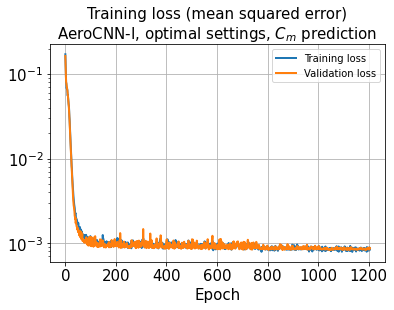

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

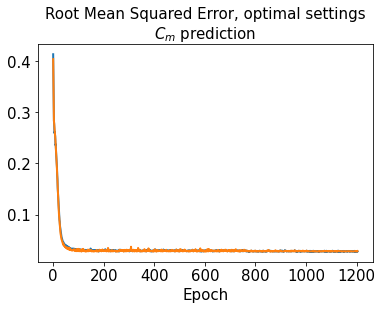

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

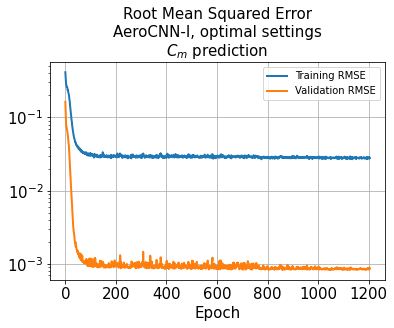

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

66/66 [==============================] - 1s 5ms/step - loss: 8.4284e-04 - rmse: 0.0279


In [37]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

19/19 [==============================] - 0s 6ms/step - loss: 8.2855e-04 - rmse: 0.0276


In [38]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

10/10 [==============================] - 0s 8ms/step - loss: 9.9747e-04 - rmse: 0.0305


In [39]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

10/10 [==============================] - 0s 2ms/step


In [40]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.06402564194012339
2.45477548611606


In [46]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.06162330101396537
2.300850723072828


In [47]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.07324059025877516
2.8682920403234227


In [48]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [49]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [50]:
model_directory = "D:\\TrainedModels\\20230102"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20230102unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly)_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [52]:
os.chdir(storage_dir)

In [53]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [56]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [57]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [58]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [59]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

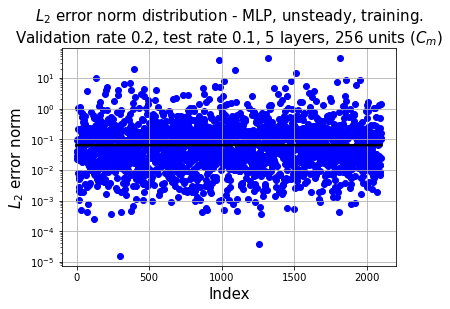

In [60]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

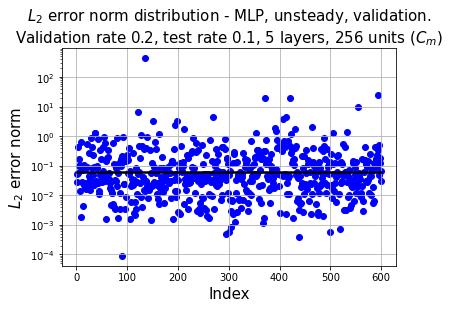

In [61]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

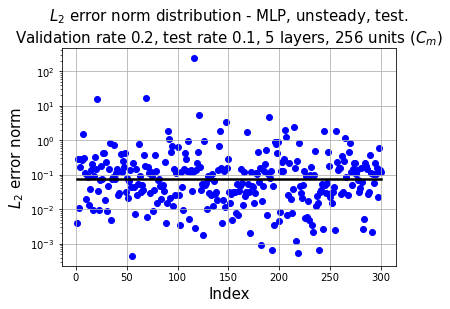

In [62]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [63]:
predicted = model.predict([x_time, x_coord])

94/94 [==============================] - 0s 2ms/step


In [64]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [65]:
max(predicted)

array([0.9602305], dtype=float32)

In [66]:
print(l2_error(predicted, y))

0.06442723176288001


In [67]:
cm[2000]

array([0.00682824])

In [68]:
cm[1000]

array([0.0014248])

In [69]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [70]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [71]:
t

array([[0.   ],
       [0.001],
       [0.002],
       ...,
       [0.997],
       [0.998],
       [0.999]])

In [72]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [73]:
len(predicted[index_train])

2100

In [74]:
len(predicted[index_val])

601

In [75]:
len(predicted[index_test])

301

In [76]:
x_time += 10

L2 error of Cm: 0.0793


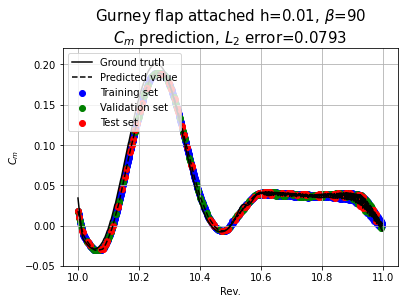

L2 error of Cm: 0.0138


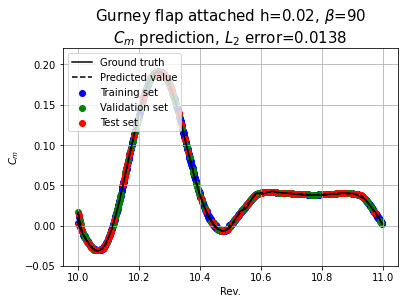

L2 error of Cm: 0.0771


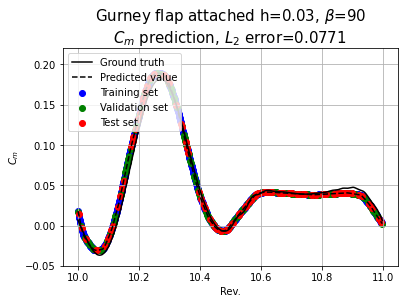

In [77]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [78]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    plt.xlim([10.17, 10.23])
    plt.ylim([0.11, 0.15])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0793


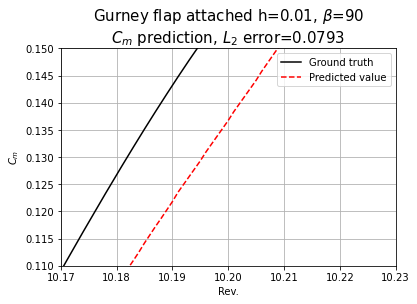

L2 error of Cm: 0.0138


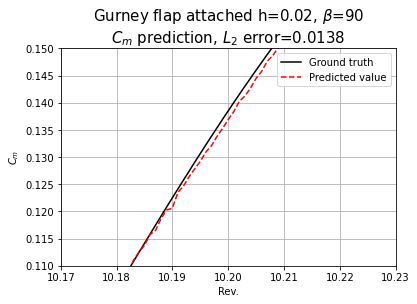

L2 error of Cm: 0.0771


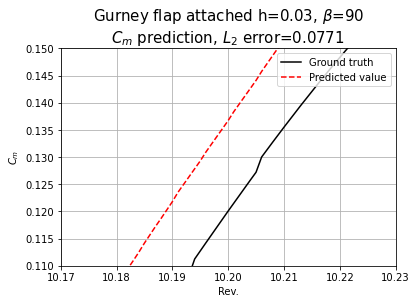

In [79]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0793


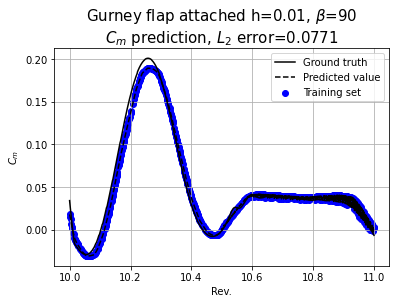

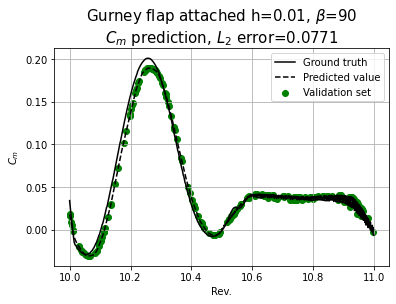

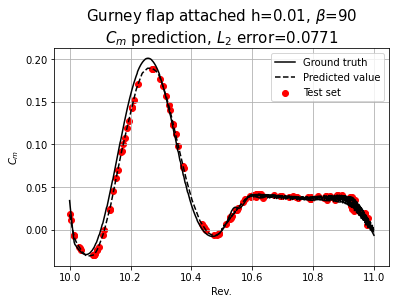

L2 error of Cm: 0.0138


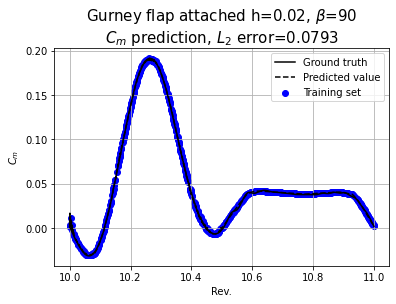

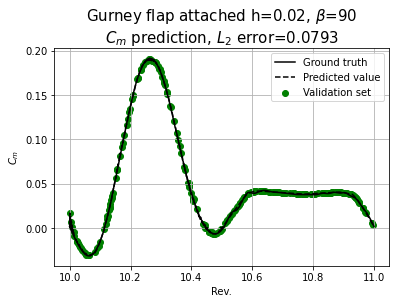

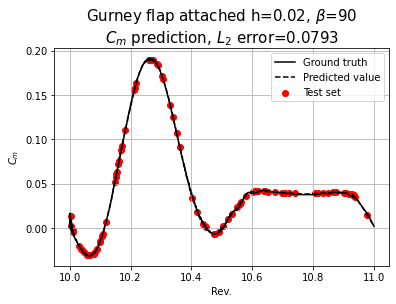

L2 error of Cm: 0.0771


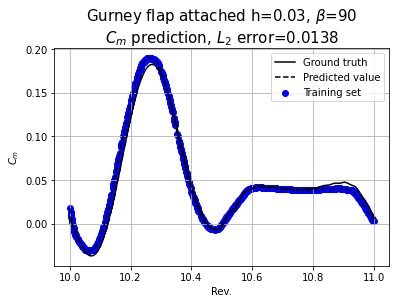

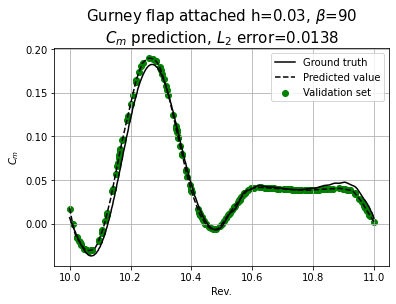

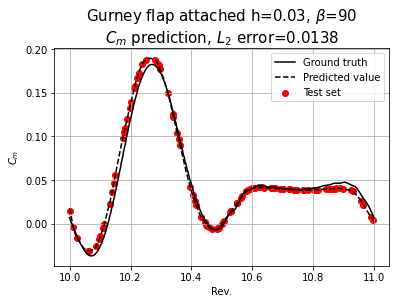

In [80]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    # Cm graph plot
    ## Training dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()